<a href="https://colab.research.google.com/github/Aryayayayaa/Shopper-Spectrum-Clustering/blob/main/Shopper_Spectrum_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name    - Aura AI - A Retail Analytics Dashboard**

# **Problem Statement:**

The global e-commerce industry generates vast amounts of transaction data daily, offering valuable insights into customer purchasing behaviors. Analyzing this data is essential for identifying meaningful customer segments and recommending relevant products to enhance customer experience and drive business growth. This project aims to examine transaction data from an online retail business to uncover patterns in customer purchase behavior, segment customers based on Recency, Frequency, and Monetary (RFM) analysis, and develop a product recommendation system using collaborative filtering techniques.

# **Project Summary:**

Aura AI is an interactive, data-driven web application built using **Streamlit**, designed to provide key insights into retail operations. The dashboard's primary objective is to empower business users to understand their customer base and optimize sales strategies through two core functionalities: **Customer Segmentation** and **Product Recommendation**.

The application leverages machine learning models and data analysis techniques to transform raw transactional data into actionable intelligence. For customer segmentation, it employs a **Recency, Frequency, Monetary (RFM) analysis** combined with a **K-Means clustering model**. This approach groups customers into distinct segments—such as "High-Value," "At-Risk," and "Recent"—based on their purchasing behavior. The app allows users to input a customer's RFM values and instantly predict which segment they belong to, providing a detailed profile and characteristics of that segment.

For product recommendation, the project utilizes an **item-based collaborative filtering model**. This functionality allows users to input a specific product name and receive a list of other products that are most similar based on historical purchase data. This helps identify cross-selling opportunities and supports personalized marketing efforts.

The dashboard features a custom-styled, aesthetically pleasing user interface with a dark theme and custom fonts, ensuring a clear and engaging user experience. Aura AI is a practical example of how data science and machine learning can be applied to solve common retail business problems, offering a comprehensive tool for customer relationship management and sales optimization.

# **GitHub Link:**


https://github.com/Aryayayayaa/Labmentix/blob/053828b34c71d8a54300dd99cfcda87718049e61/Shopper_Spectrum_Clustering.ipynb

# **Code -**

In [ ]:
# @title Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px                                                     # better for interactive radar charts
import plotly.graph_objects as go
import seaborn as sns
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.metrics import silhouette_score
import datetime as dt
import joblib                                                                   # For saving the model
from mpl_toolkits.mplot3d import Axes3D                                         # For 3D plot
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from google.colab import drive

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# @title Google Drive + Load Dataset

# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Shopper Spectrum Clustering/online_retail.csv'

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please check the file path and ensure the dataset is uploaded to your Google Drive.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Mounted at /content/drive
Dataset loaded successfully!


In [ ]:
# @title Data Exploration

print("\n--- Initial Data Exploration ---")


# Display the first few rows of the dataset to get a glimpse of the data
print("1. First 5 rows of the dataset:")
print(df.head())


# Get a concise summary of the DataFrame, including data types and non-null values
print("\n2. DataFrame Info:")
df.info()

# Get descriptive statistics for numerical columns
print("\n3. Descriptive Statistics for Numerical Columns:")
print(df.describe())


# Check for missing values
print("\n4. Missing Values (count and percentage):")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Percentage (%)': missing_percentage})
print(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False))
if missing_df['Missing Count'].sum() == 0:
    print("No missing values found!")


# Check for duplicate rows
print("\n5. Number of Duplicate Rows:")
duplicate_rows = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows}")
if duplicate_rows > 0:
    print("Consider dropping duplicates later if they represent exact repetitions of entire transactions.")


# Check for unusual records in 'Quantity' and 'UnitPrice' (e.g., negative values)
print("\n6. Checking for unusual values in 'Quantity' and 'UnitPrice':")
print(f"Quantity - Minimum value: {df['Quantity'].min()}")
print(f"Quantity - Maximum value: {df['Quantity'].max()}")
print(f"UnitPrice - Minimum value: {df['UnitPrice'].min()}")
print(f"UnitPrice - Maximum value: {df['UnitPrice'].max()}")

# Identify transactions with negative Quantity (usually returns/cancellations)
negative_quantity_transactions = df[df['Quantity'] < 0]
print(f"\nNumber of transactions with negative Quantity (potential returns): {len(negative_quantity_transactions)}")
if not negative_quantity_transactions.empty:
    print("Examples of negative Quantity transactions:")
    print(negative_quantity_transactions.head())

# Identify transactions with UnitPrice = 0 (might be free items, missing prices, or data errors)
zero_unitprice_transactions = df[df['UnitPrice'] == 0]
print(f"\nNumber of transactions with UnitPrice = 0: {len(zero_unitprice_transactions)}")
if not zero_unitprice_transactions.empty:
    print("Examples of UnitPrice = 0 transactions:")
    print(zero_unitprice_transactions.head())

# Explore unique values for categorical columns (if applicable)
print("\n7. Unique values in 'InvoiceNo' (first 10 if many):")
print(df['InvoiceNo'].nunique())
if df['InvoiceNo'].nunique() > 10:
    print(df['InvoiceNo'].value_counts().head(10))
else:
    print(df['InvoiceNo'].value_counts())


print("\n8. Unique values in 'StockCode' (first 10 if many):")
print(df['StockCode'].nunique())
if df['StockCode'].nunique() > 10:
    print(df['StockCode'].value_counts().head(10))
else:
    print(df['StockCode'].value_counts())


print("\n9. Unique values in 'Description' (first 10 if many):")
print(df['Description'].nunique())
if df['Description'].nunique() > 10:
    print(df['Description'].value_counts().head(10))
else:
    print(df['Description'].value_counts())


print("\n10. Unique values in 'Country':")
print(df['Country'].nunique())
print(df['Country'].value_counts().head()) # Display top 5 countries


print("\n--- Initial Data Exploration Complete ---")


--- Initial Data Exploration ---
1. First 5 rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  

2. DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total

In [ ]:
# @title Data Preprocessing
#.copy() function used to avoid SettingWithCopyWarning

print("--- Starting Data Preprocessing ---")

initial_rows = df.shape[0]
print(f"Initial DataFrame shape: {df.shape}")

# Remove rows with missing CustomerID
df_cleaned = df.dropna(subset=['CustomerID']).copy()
rows_after_customer_id_removal = df_cleaned.shape[0]
print(f"Shape after removing rows with missing CustomerID: {df_cleaned.shape}")
print(f"Number of rows removed (missing CustomerID): {initial_rows - rows_after_customer_id_removal}")


# Convert CustomerID to integer type
df_cleaned.loc[:, 'CustomerID'] = df_cleaned['CustomerID'].astype(int)
print("CustomerID column converted to integer type.")


# Store the shape before the next filtering step for accurate reporting
rows_before_cancel_filter = df_cleaned.shape[0]


# Exclude cancelled invoices (InvoiceNo starting with 'C') - this filter should also implicitly handle cases where InvoiceNo might not be a string
df_cleaned = df_cleaned[~df_cleaned['InvoiceNo'].astype(str).str.startswith('C')].copy()
rows_after_cancel_filter = df_cleaned.shape[0]
print(f"Shape after excluding cancelled invoices: {df_cleaned.shape}")
print(f"Number of rows removed (cancelled invoices): {rows_before_cancel_filter - rows_after_cancel_filter}")


# Store the shape before the next filtering step for accurate reporting
rows_before_qty_price_filter = df_cleaned.shape[0]


# Remove negative or zero quantities and prices
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)].copy()
rows_after_qty_price_filter = df_cleaned.shape[0]
print(f"Shape after removing non-positive quantities and prices: {df_cleaned.shape}")
print(f"Number of rows removed (non-positive quantities/prices): {rows_before_qty_price_filter - rows_after_qty_price_filter}")


# --- Preprocessing Summary ---
final_rows = df_cleaned.shape[0]
print(f"\n--- Preprocessing Summary ---")
print(f"Initial rows: {initial_rows}")
print(f"Rows after removing missing CustomerID: {rows_after_customer_id_removal}")
print(f"Rows after excluding cancelled invoices: {rows_after_cancel_filter}")
print(f"Rows after removing non-positive quantities/prices: {final_rows}")
print(f"Total rows removed during preprocessing: {initial_rows - final_rows}")

print("\n--- Data Preprocessing Complete ---")


print("\nFirst 5 rows of the cleaned DataFrame:")
print(df_cleaned.head())

print("\nCleaned DataFrame Info:")
df_cleaned.info()

print("\nDescriptive statistics for cleaned data:")
print(df_cleaned.describe())


# Check for remaining issues
print("\n--- Post-Preprocessing Checks ---")
print(f"Missing values remaining:\n{df_cleaned.isnull().sum()}")
print(f"Negative Quantity remaining: {(df_cleaned['Quantity'] <= 0).sum()}")
print(f"Zero UnitPrice remaining: {(df_cleaned['UnitPrice'] <= 0).sum()}")
print(f"InvoiceNo starting with 'C' remaining: {df_cleaned['InvoiceNo'].astype(str).str.startswith('C').sum()}")

--- Starting Data Preprocessing ---
Initial DataFrame shape: (541909, 8)
Shape after removing rows with missing CustomerID: (406829, 8)
Number of rows removed (missing CustomerID): 135080
CustomerID column converted to integer type.
Shape after excluding cancelled invoices: (397924, 8)
Number of rows removed (cancelled invoices): 8905
Shape after removing non-positive quantities and prices: (397884, 8)
Number of rows removed (non-positive quantities/prices): 40

--- Preprocessing Summary ---
Initial rows: 541909
Rows after removing missing CustomerID: 406829
Rows after excluding cancelled invoices: 397924
Rows after removing non-positive quantities/prices: 397884
Total rows removed during preprocessing: 144025

--- Data Preprocessing Complete ---

First 5 rows of the cleaned DataFrame:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN 

In [ ]:
# @title Before EDA

#Before EDA:

# Convert 'InvoiceDate' to datetime objects - for time-based analysis and eventually for RFM's Recency calculation
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
print("Converted 'InvoiceDate' to datetime type.")
print(f"InvoiceDate min: {df_cleaned['InvoiceDate'].min()}")
print(f"InvoiceDate max: {df_cleaned['InvoiceDate'].max()}")


# Create 'TotalPrice' column - essential for understanding monetary value per transaction item.
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']
print("Created 'TotalPrice' column (Quantity * UnitPrice).")

print("--- Essential Feature Engineering Complete ---")

print("\nFirst 5 rows of DataFrame with new features:")
print(df_cleaned.head())

print("\nDataFrame Info after Essential Feature Engineering:")
df_cleaned.info()

print("\nDescriptive statistics for TotalPrice:")
print(df_cleaned['TotalPrice'].describe())

Converted 'InvoiceDate' to datetime type.
InvoiceDate min: 2022-12-01 08:26:00
InvoiceDate max: 2023-12-09 12:50:00
Created 'TotalPrice' column (Quantity * UnitPrice).
--- Essential Feature Engineering Complete ---

First 5 rows of DataFrame with new features:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2022-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1 2022-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2 2022-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3 


--- Starting Exploratory Data Analysis (EDA) ---

1. Transaction Volume by Country:
Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: count, dtype: int64


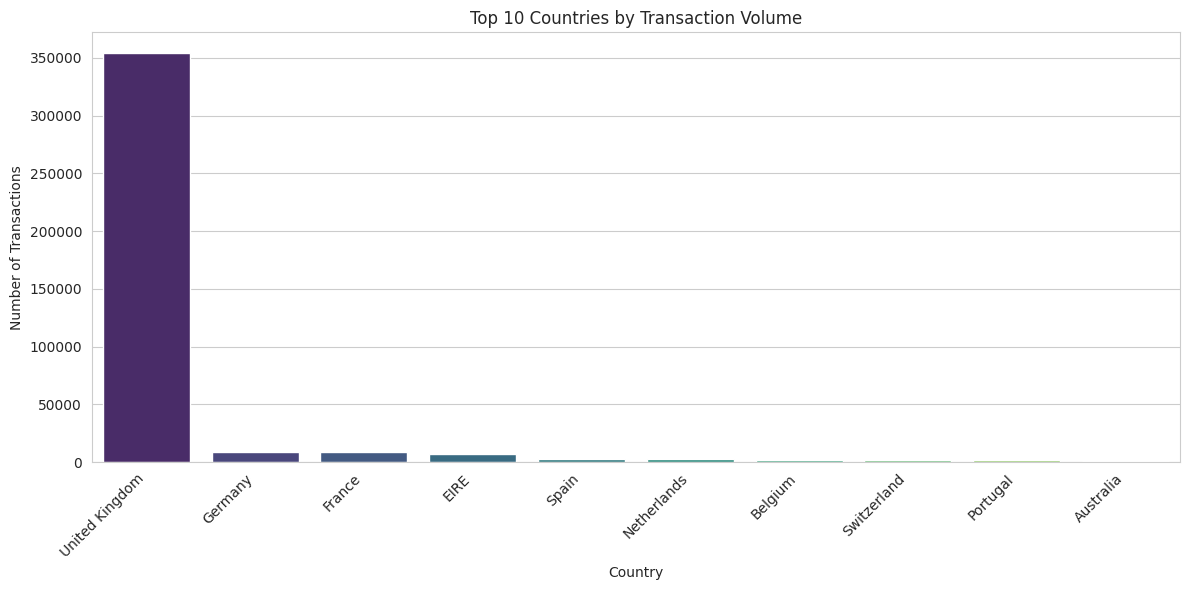


Total Sales (Monetary Value) by Country:
Country
United Kingdom    7308391.554
Netherlands        285446.340
EIRE               265545.900
Germany            228867.140
France             209024.050
Australia          138521.310
Spain               61577.110
Switzerland         56443.950
Belgium             41196.340
Sweden              38378.330
Name: TotalPrice, dtype: float64


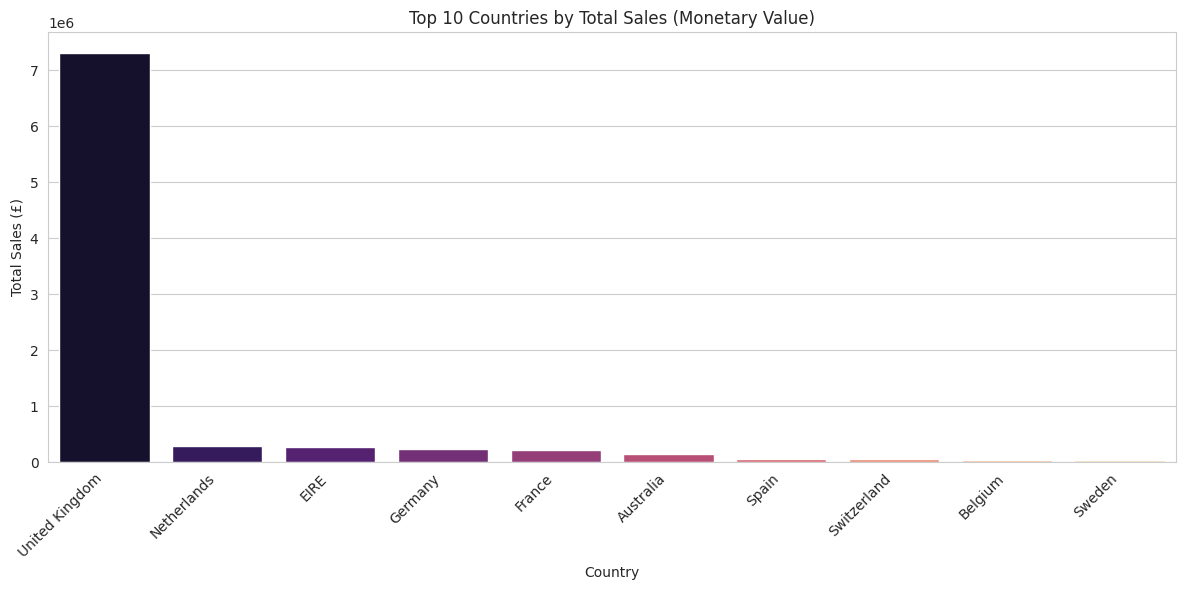


2. Top-Selling Products:
Top-Selling Products (by Quantity):
 Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
ASSORTED COLOUR BIRD ORNAMENT         35362
PACK OF 72 RETROSPOT CAKE CASES       33693
POPCORN HOLDER                        30931
RABBIT NIGHT LIGHT                    27202
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64


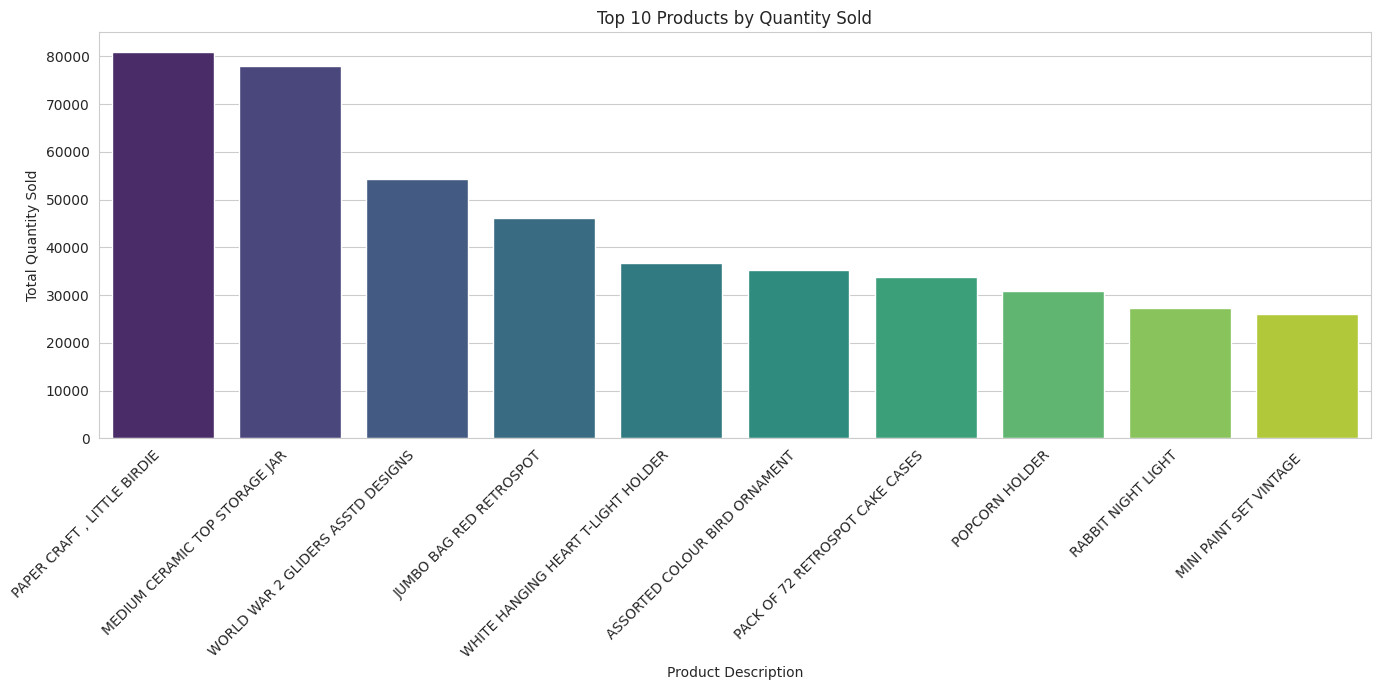


Top-Selling Products (by Total Sales Value):
 Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142592.95
WHITE HANGING HEART T-LIGHT HOLDER    100448.15
JUMBO BAG RED RETROSPOT                85220.78
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68844.33
ASSORTED COLOUR BIRD ORNAMENT          56580.34
Manual                                 53779.93
RABBIT NIGHT LIGHT                     51346.20
Name: TotalPrice, dtype: float64


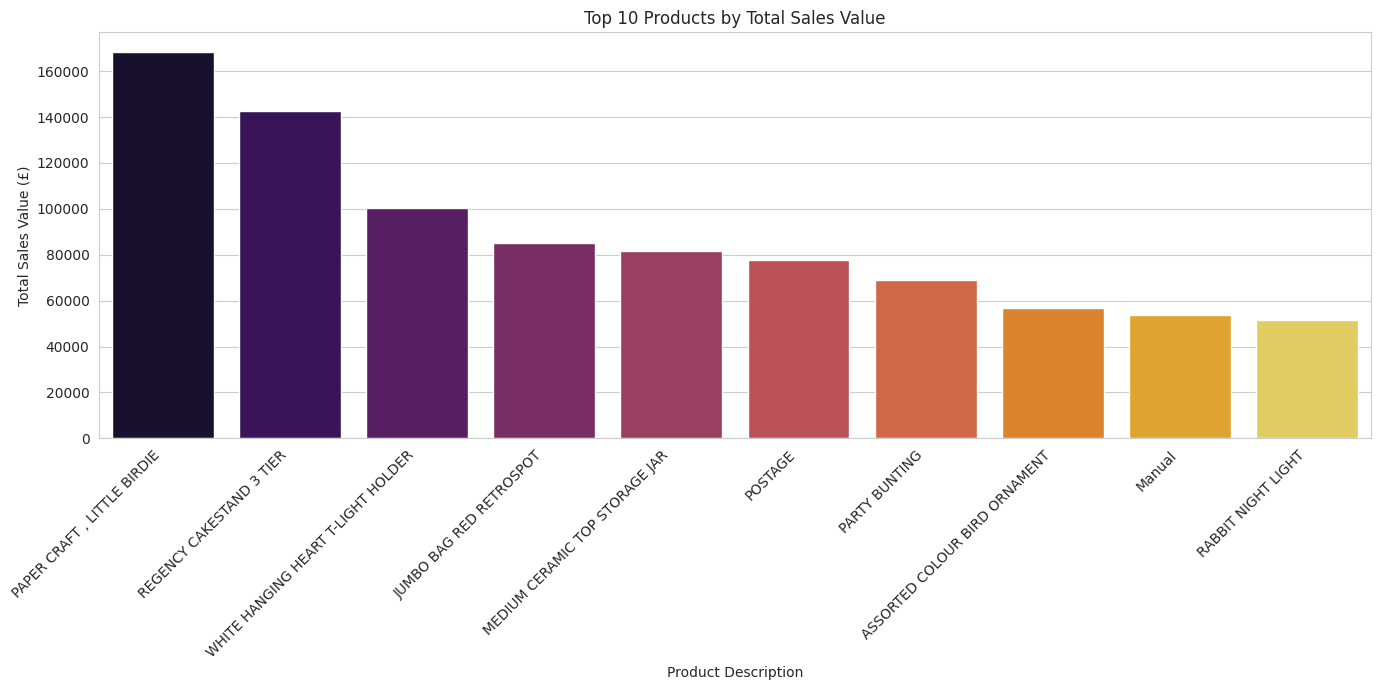


3. Purchase Trends over Time:


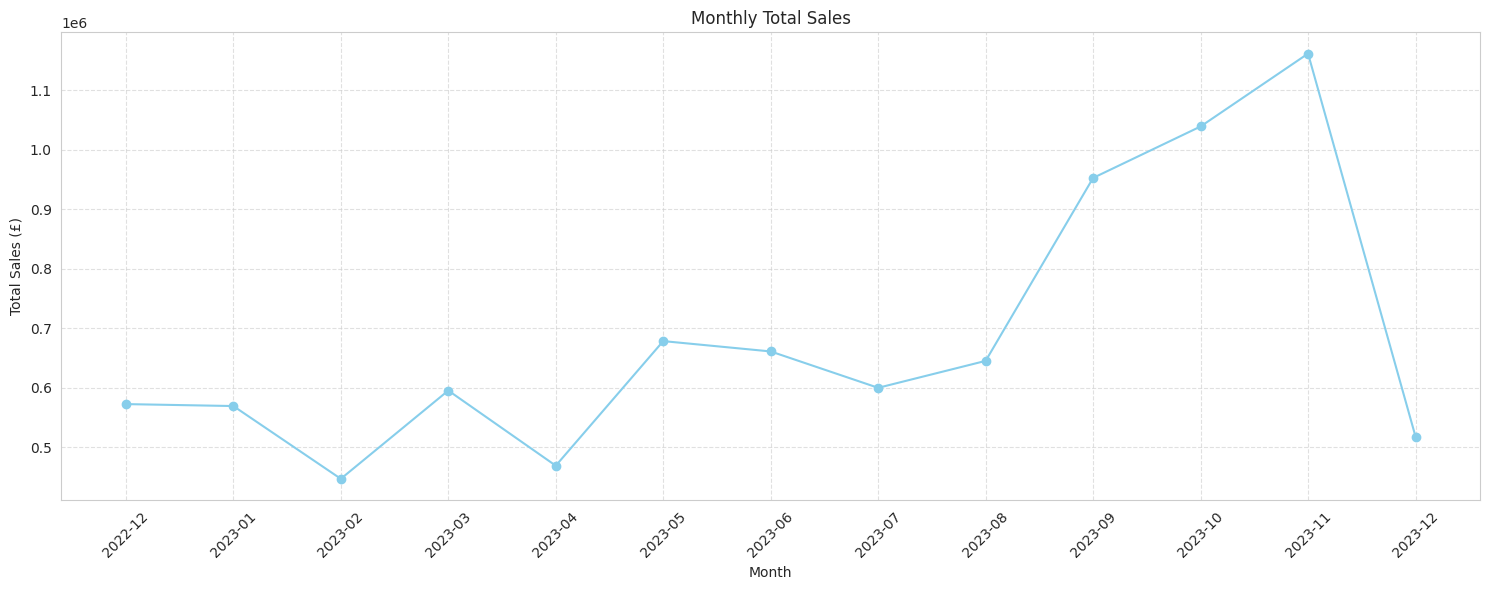

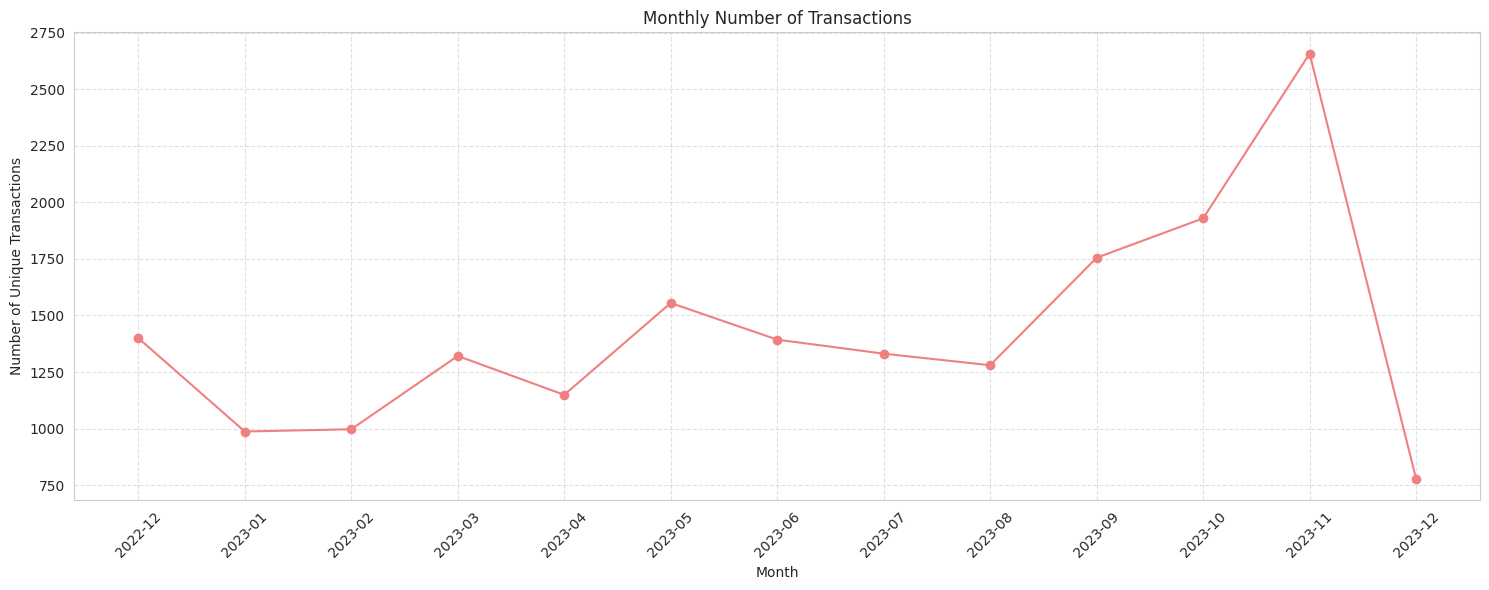

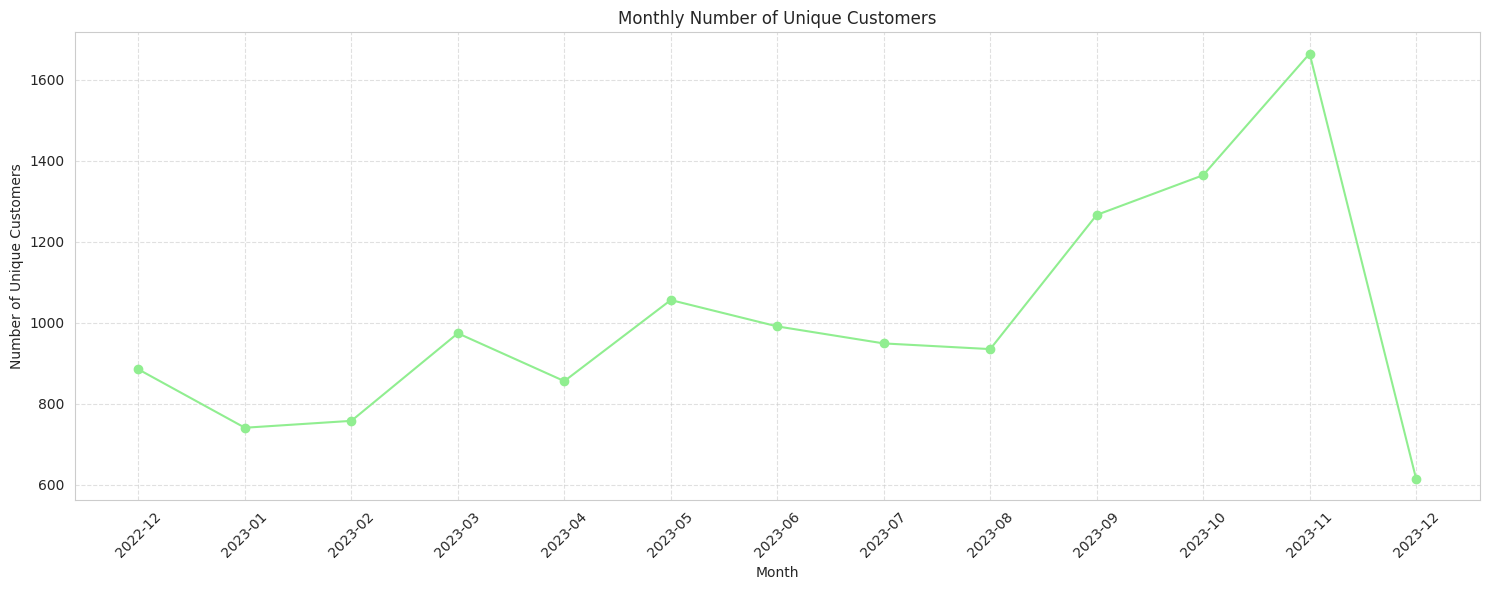

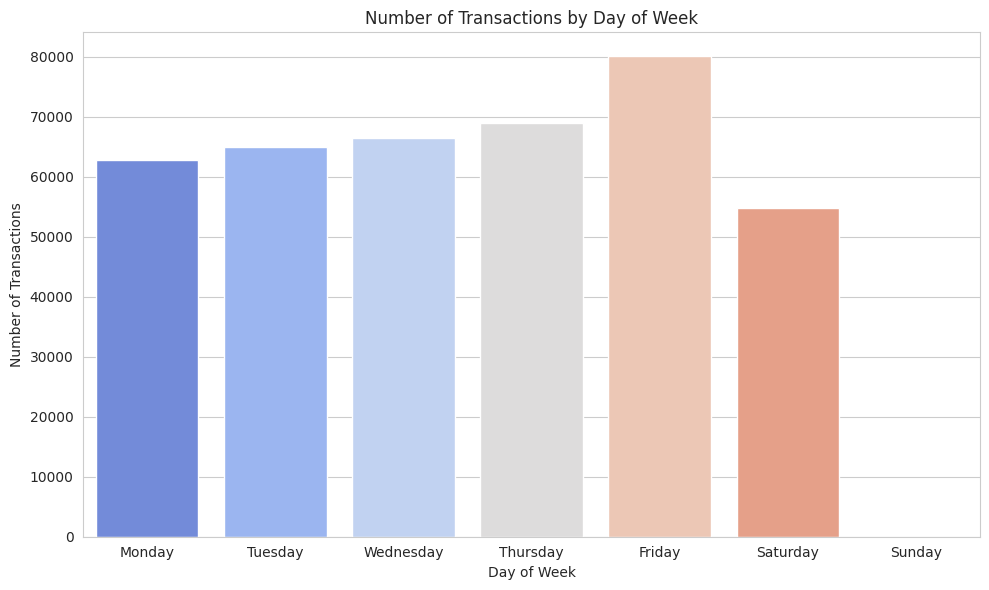

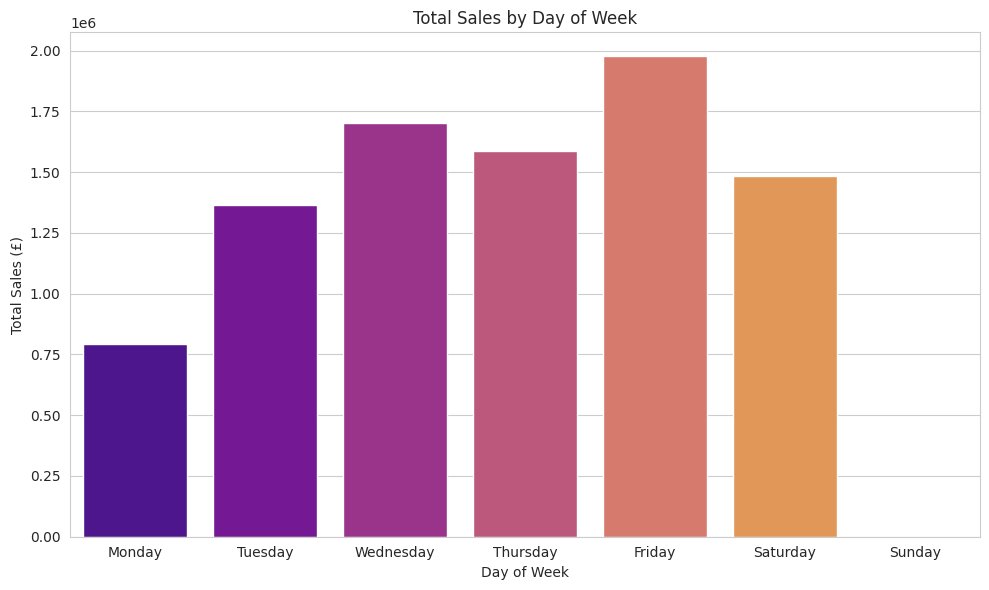


4. Monetary Distribution Per Transaction Item:


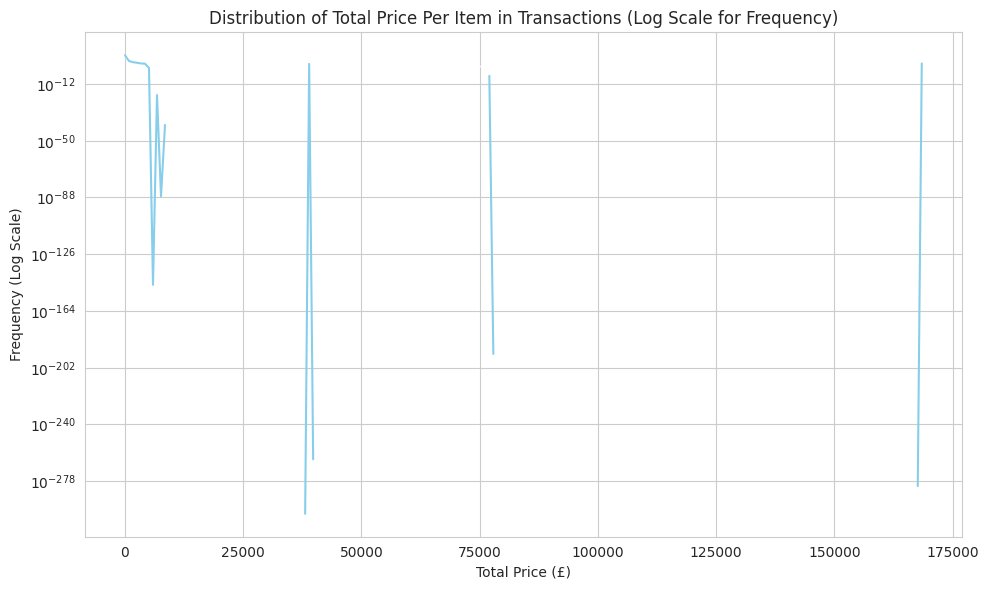

Average TotalPrice per item: £22.40
Median TotalPrice per item: £11.80

4. Monetary Distribution Per Invoice:


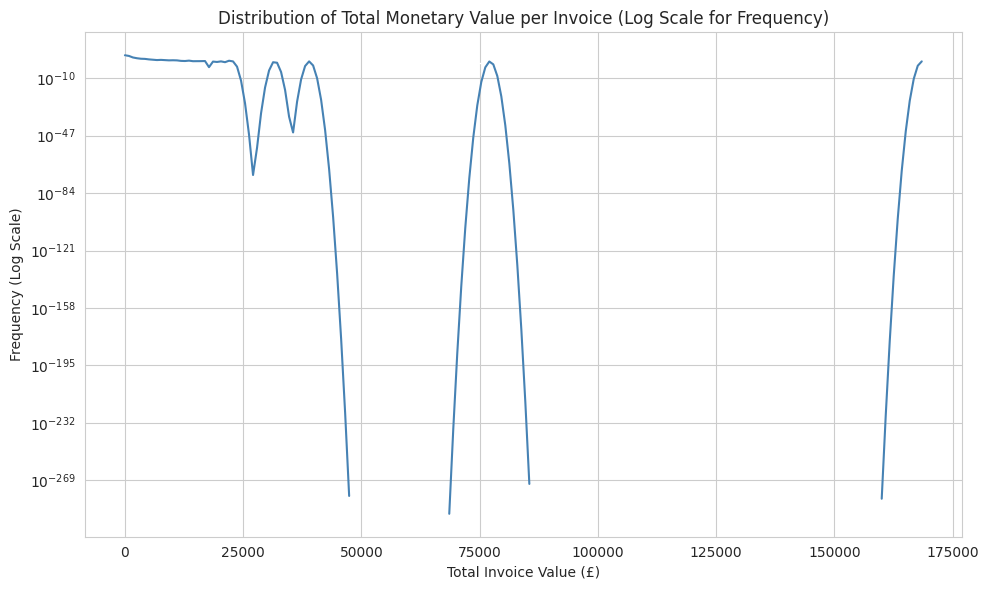

Average Total Monetary Value per Invoice: £480.87
Median Total Monetary Value per Invoice: £303.04

5. Product Co-occurrence (example):
Top 10 Product Co-occurrences:
Count: 546, Products: JUMBO BAG PINK POLKADOT & JUMBO BAG RED RETROSPOT
Count: 541, Products: GREEN REGENCY TEACUP AND SAUCER & ROSES REGENCY TEACUP AND SAUCER 
Count: 530, Products: ALARM CLOCK BAKELIKE GREEN & ALARM CLOCK BAKELIKE RED 
Count: 523, Products: LUNCH BAG PINK POLKADOT & LUNCH BAG RED RETROSPOT
Count: 517, Products: LUNCH BAG  BLACK SKULL. & LUNCH BAG RED RETROSPOT
Count: 468, Products: WOODEN FRAME ANTIQUE WHITE  & WOODEN PICTURE FRAME WHITE FINISH
Count: 467, Products: LUNCH BAG RED RETROSPOT & LUNCH BAG SPACEBOY DESIGN 
Count: 464, Products: LUNCH BAG  BLACK SKULL. & LUNCH BAG PINK POLKADOT
Count: 463, Products: GARDENERS KNEELING PAD CUP OF TEA  & GARDENERS KNEELING PAD KEEP CALM 
Count: 460, Products: GREEN REGENCY TEACUP AND SAUCER & PINK REGENCY TEACUP AND SAUCER

--- Exploratory Data Analysis (EDA) C

In [ ]:
# @title EDA

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size


print("\n--- Starting Exploratory Data Analysis (EDA) ---")


# 1. Transaction Volume and Sales by Country
print("\n1. Transaction Volume by Country:")
country_transactions = df_cleaned['Country'].value_counts()
print(country_transactions.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x=country_transactions.index[:10], y=country_transactions.values[:10],
            hue=country_transactions.index[:10], palette='viridis', legend=False)
plt.title('Top 10 Countries by Transaction Volume')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nTotal Sales (Monetary Value) by Country:")
country_sales = df_cleaned.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
print(country_sales.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x=country_sales.index[:10], y=country_sales.values[:10],
            hue=country_sales.index[:10], palette='magma', legend=False)
plt.title('Top 10 Countries by Total Sales (Monetary Value)')
plt.xlabel('Country')
plt.ylabel('Total Sales (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# 2. Top-Selling Products
print("\n2. Top-Selling Products:")
top_products_qty = df_cleaned.groupby('Description')['Quantity'].sum().sort_values(ascending=False)
print("Top-Selling Products (by Quantity):\n", top_products_qty.head(10))

plt.figure(figsize=(14, 7))
sns.barplot(x=top_products_qty.index[:10], y=top_products_qty.values[:10],
            hue=top_products_qty.index[:10], palette='viridis', legend=False)
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Product Description')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

top_products_sales = df_cleaned.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
print("\nTop-Selling Products (by Total Sales Value):\n", top_products_sales.head(10))

plt.figure(figsize=(14, 7))
sns.barplot(x=top_products_sales.index[:10], y=top_products_sales.values[:10],
            hue=top_products_sales.index[:10], palette='inferno', legend=False)
plt.title('Top 10 Products by Total Sales Value')
plt.xlabel('Product Description')
plt.ylabel('Total Sales Value (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# 3. Purchase Trends over Time
print("\n3. Purchase Trends over Time:")
df_cleaned['InvoiceMonth'] = df_cleaned['InvoiceDate'].dt.to_period('M')
monthly_sales = df_cleaned.groupby('InvoiceMonth')['TotalPrice'].sum()
monthly_transactions = df_cleaned.groupby('InvoiceMonth')['InvoiceNo'].nunique()
monthly_unique_customers = df_cleaned.groupby('InvoiceMonth')['CustomerID'].nunique()

plt.figure(figsize=(15, 6))
plt.plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o', color='skyblue', label='Total Sales')
plt.title('Monthly Total Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(monthly_transactions.index.astype(str), monthly_transactions.values, marker='o', color='lightcoral', label='Number of Unique Transactions')
plt.title('Monthly Number of Transactions')
plt.xlabel('Month')
plt.ylabel('Number of Unique Transactions')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(monthly_unique_customers.index.astype(str), monthly_unique_customers.values, marker='o', color='lightgreen', label='Number of Unique Customers')
plt.title('Monthly Number of Unique Customers')
plt.xlabel('Month')
plt.ylabel('Number of Unique Customers')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Day of Week Analysis
df_cleaned['DayOfWeek'] = df_cleaned['InvoiceDate'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
transactions_by_day = df_cleaned['DayOfWeek'].value_counts().reindex(day_order).fillna(0)
sales_by_day = df_cleaned.groupby('DayOfWeek')['TotalPrice'].sum().reindex(day_order).fillna(0)


plt.figure(figsize=(10, 6))
sns.barplot(x=transactions_by_day.index, y=transactions_by_day.values,
            hue=transactions_by_day.index, palette='coolwarm', legend=False)
plt.title('Number of Transactions by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_day.index, y=sales_by_day.values,
            hue=sales_by_day.index, palette='plasma', legend=False)
plt.title('Total Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales (£)')
plt.tight_layout()
plt.show()



# 4. Monetary Distribution Per Transaction Item
print("\n4. Monetary Distribution Per Transaction Item:")
plt.figure(figsize=(10, 6))

# Apply log transformation to the TotalPrice column before plotting for better visualization of skewed data
# use a histogram with log scale on Y-axis for frequency, and normal scale on X for price
sns.histplot(df_cleaned['TotalPrice'], bins=50, kde=True, color='skyblue', log_scale=(False, True)) # Only Y-axis is log
plt.title('Distribution of Total Price Per Item in Transactions (Log Scale for Frequency)')
plt.xlabel('Total Price (£)')
plt.ylabel('Frequency (Log Scale)')
plt.xscale('linear')                                                            # Ensure X-axis is linear
plt.tight_layout()
plt.show()

print(f"Average TotalPrice per item: £{df_cleaned['TotalPrice'].mean():.2f}")
print(f"Median TotalPrice per item: £{df_cleaned['TotalPrice'].median():.2f}")


# Monetary Distribution Per Invoice
print("\n4. Monetary Distribution Per Invoice:")
invoice_monetary = df_cleaned.groupby('InvoiceNo')['TotalPrice'].sum()

plt.figure(figsize=(10, 6))
# Apply log transformation to the TotalPrice column before plotting for better visualization of skewed data
# We'll use a histogram with log scale on Y-axis for frequency, and normal scale on X for price
sns.histplot(invoice_monetary, bins=50, kde=True, color='steelblue', log_scale=(False, True)) # Only Y-axis is log
plt.title('Distribution of Total Monetary Value per Invoice (Log Scale for Frequency)')
plt.xlabel('Total Invoice Value (£)')
plt.ylabel('Frequency (Log Scale)')
plt.xscale('linear')                                                            # Ensure X-axis is linear
plt.tight_layout()
plt.show()

print(f"Average Total Monetary Value per Invoice: £{invoice_monetary.mean():.2f}")
print(f"Median Total Monetary Value per Invoice: £{invoice_monetary.median():.2f}")



# 5. Product Co-occurrence
print("\n5. Product Co-occurrence (example):")

# Get all products per invoice
invoice_products = df_cleaned.groupby('InvoiceNo')['Description'].apply(list)

# Generate pairs of products that appear together - can be computationally intensive for many transactions with many items
product_pairs = Counter()
for products in invoice_products:
    # Ensure unique products within an invoice for combinations
    unique_products_in_invoice = sorted(list(set(products))) # Sort for consistent pairing
    for p1, p2 in combinations(unique_products_in_invoice, 2):
        product_pairs[(p1, p2)] += 1

# Get the top 10 most common product pairs
top_product_pairs = product_pairs.most_common(10)
print("Top 10 Product Co-occurrences:")
for pair, count in top_product_pairs:
    print(f"Count: {count}, Products: {pair[0]} & {pair[1]}")

print("\n--- Exploratory Data Analysis (EDA) Complete ---")

--- Starting Clustering Methodology ---

RFM DataFrame head:
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40

Descriptive statistics for RFM values:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000

Visualizing RFM Distributions:


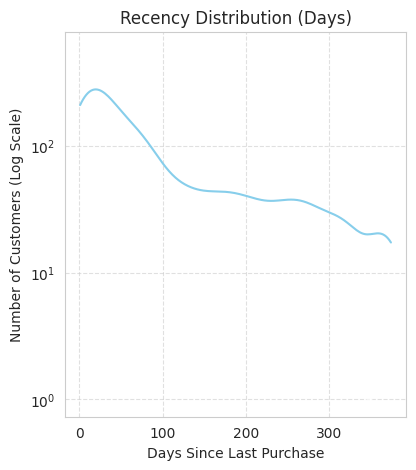

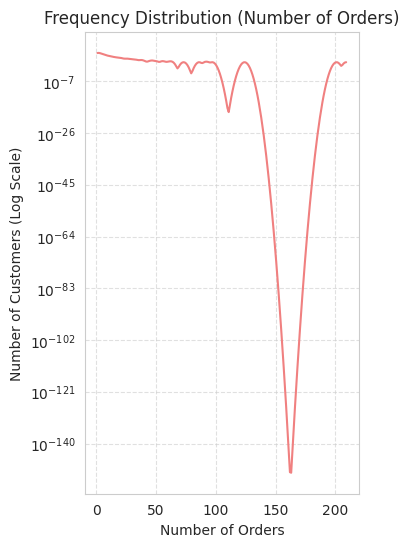

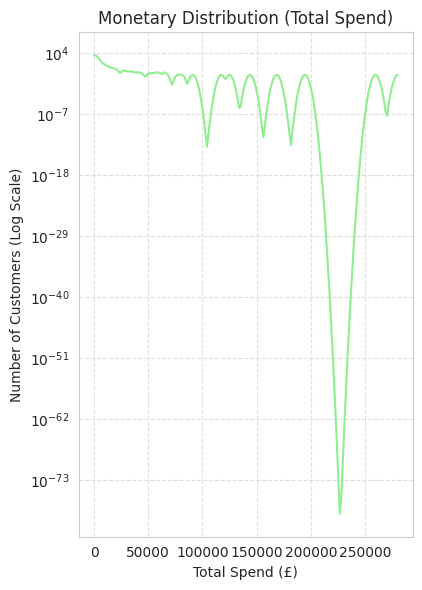


RFM DataFrame after Log Transformation (head):
   CustomerID   Recency  Frequency   Monetary
0       12346  5.789960   0.693147  11.253955
1       12347  1.098612   2.079442   8.368925
2       12348  4.330733   1.609438   7.494564
3       12349  2.995732   0.693147   7.472245
4       12350  5.739793   0.693147   5.815324

Descriptive statistics for RFM values after Log Transformation:
           Recency    Frequency     Monetary
count  4338.000000  4338.000000  4338.000000
mean      3.830734     1.345582     6.593627
std       1.340261     0.683104     1.257578
min       0.693147     0.693147     1.558145
25%       2.944439     0.693147     5.731446
50%       3.951244     1.098612     6.515431
75%       4.962845     1.791759     7.416222
max       5.926926     5.347108    12.543284

RFM DataFrame after Scaling (head):
            Recency_Scaled  Frequency_Scaled  Monetary_Scaled
CustomerID                                                   
12346             1.461993         -0.955214 

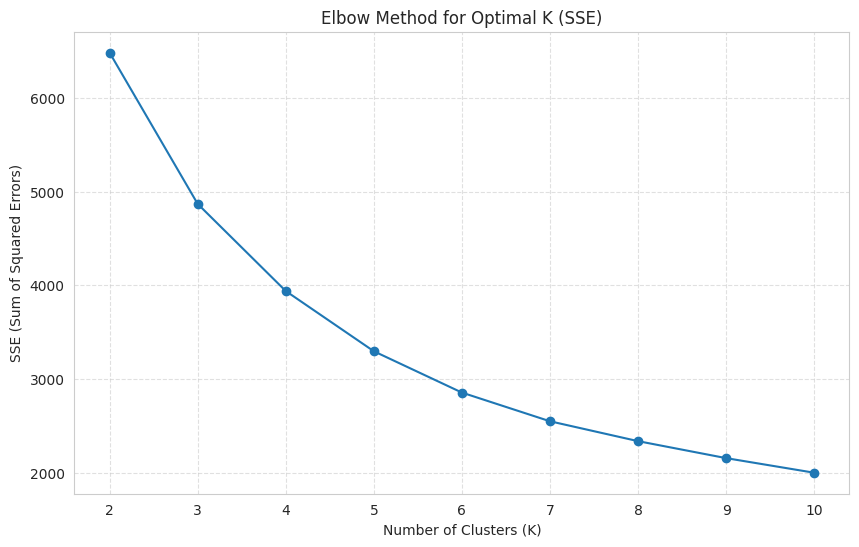

Interpretation: Look for the 'elbow' point where the decrease in SSE starts to slow down significantly.

Applying Silhouette Score for Optimal K:


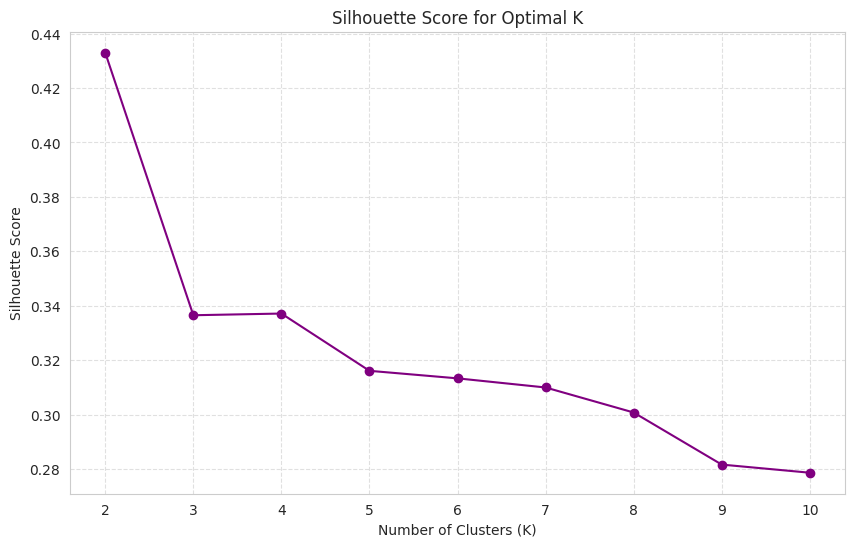

Interpretation: A higher Silhouette Score generally indicates better defined clusters.

Proceeding with K-Means clustering with optimal_k = 4

RFM DataFrame with Cluster Labels (head):
   CustomerID  Recency  Frequency  Monetary  Cluster
0       12346      326          1  77183.60        2
1       12347        2          7   4310.00        1
2       12348       75          4   1797.24        2
3       12349       19          1   1757.55        0
4       12350      310          1    334.40        3

--- Visualizing Clusters ---


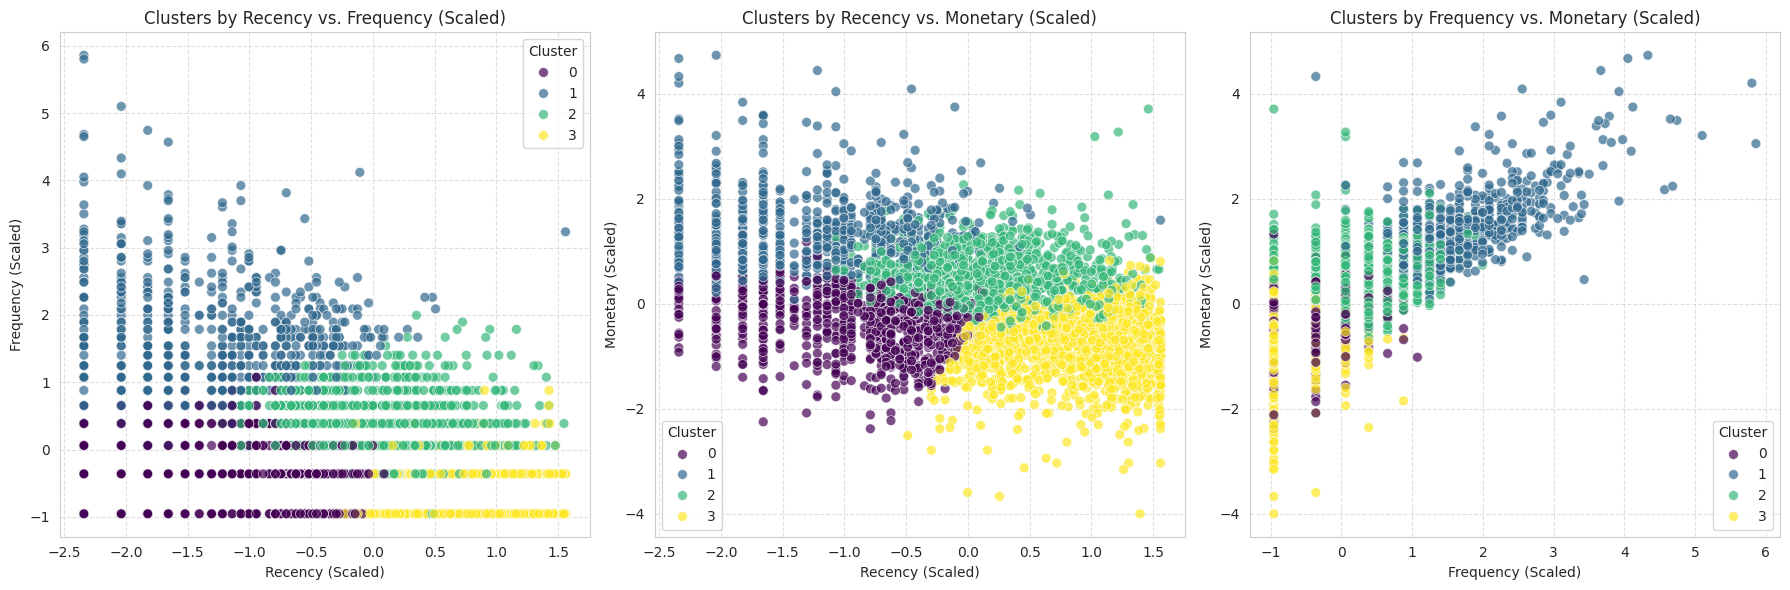

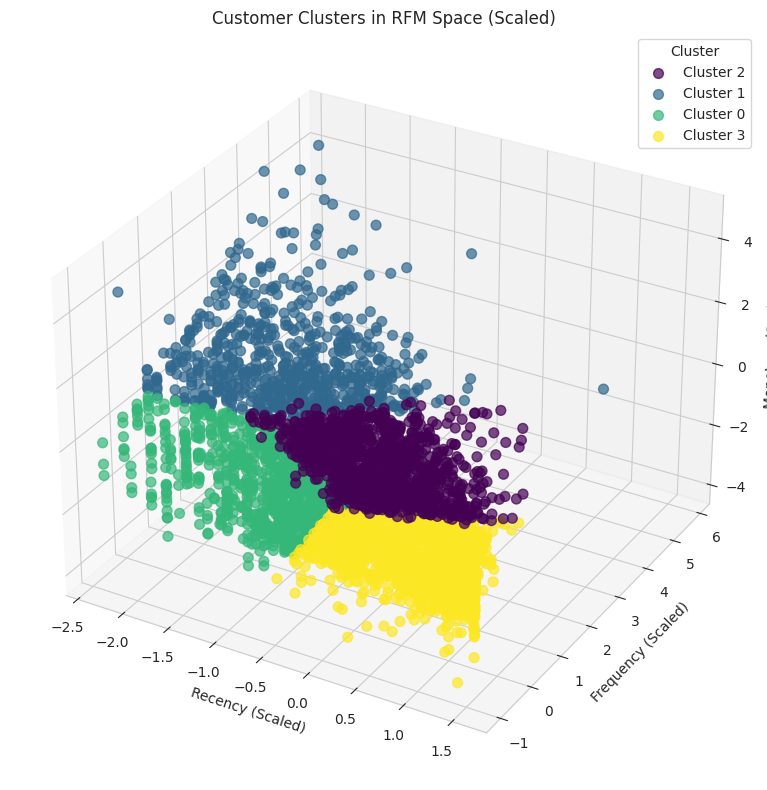


--- Saving the K-Means Model and Scaler ---
K-Means model saved to kmeans_model.joblib
Scaler saved to scaler.joblib
RFM DataFrame with clusters saved to rfm_data_with_clusters.csv

--- Model and Scaler Saved for Streamlit ---

Customer Cluster Profiles (Avg RFM on original scale):
         AvgRecency  AvgFrequency  AvgMonetary  NumCustomers  \
Cluster                                                        
0             18.12          2.15       551.82           837   
1             12.13         13.71      8074.27           716   
2             71.08          4.08      1802.83          1173   
3            182.50          1.32       343.45          1612   

         PercentageOfCustomers  
Cluster                         
0                        19.29  
1                        16.51  
2                        27.04  
3                        37.16  

Cluster profiles table saved to rfm_cluster_profiles.csv

Visualizing Cluster Profiles with Radar Chart



Analyzing Top Products Per Cluster 

Top 5 Products by Quantity per Cluster:

--- Cluster 0 ---
      Cluster                          Description  Quantity
171         0        ASSORTED COLOUR BIRD ORNAMENT      2205
2992        0    WORLD WAR 2 GLIDERS ASSTD DESIGNS      1920
2977        0   WOODEN STAR CHRISTMAS SCANDINAVIAN      1861
2828        0         VINTAGE DOILY JUMBO BAG RED       1640
2970        0  WOODEN HEART CHRISTMAS SCANDINAVIAN      1633

--- Cluster 1 ---
      Cluster                        Description  Quantity
5241        1        PAPER CRAFT , LITTLE BIRDIE     80995
6638        1  WORLD WAR 2 GLIDERS ASSTD DESIGNS     35159
4715        1            JUMBO BAG RED RETROSPOT     34415
5500        1                     POPCORN HOLDER     25490
5548        1                 RABBIT NIGHT LIGHT     23520

--- Cluster 2 ---
       Cluster                         Description  Quantity
8477         2      MEDIUM CERAMIC TOP STORAGE JAR     74910
9581         2         

In [ ]:
# @title Clustering Methodolgy

print("--- Starting Clustering Methodology ---")

# Ensure 'InvoiceDate' is datetime and 'CustomerID' is integer
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)


# 1. Calculate RFM Values
# snapshot date = one day after the last transaction date
snapshot_date = df_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by CustomerID and calculate RFM
rfm = df_cleaned.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days),    # Days since last purchase
    Frequency=('InvoiceNo', 'nunique'),                                         # Number of unique invoices
    Monetary=('TotalPrice', 'sum')                                              # Total monetary value
).reset_index()

print("\nRFM DataFrame head:")
print(rfm.head())

print("\nDescriptive statistics for RFM values:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())



print("\nVisualizing RFM Distributions:")

plt.figure(figsize=(15, 5))

# Recency distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=50, kde=True, color='skyblue', log_scale=(False, True)) # Log scale for frequency
plt.title('Recency Distribution (Days)')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Customers (Log Scale)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Frequency distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=50, kde=True, color='lightcoral', log_scale=(False, True)) # Log scale for frequency
plt.title('Frequency Distribution (Number of Orders)')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers (Log Scale)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Monetary distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=50, kde=True, color='lightgreen', log_scale=(False, True)) # Log scale for frequency
plt.title('Monetary Distribution (Total Spend)')
plt.xlabel('Total Spend (£)')
plt.ylabel('Number of Customers (Log Scale)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()



# 2. Handle Skewness (Log Transformation) -> log transformation to handle skewness, add a small constant to avoid log(0)
rfm_log = rfm.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

print("\nRFM DataFrame after Log Transformation (head):")
print(rfm_log.head())

print("\nDescriptive statistics for RFM values after Log Transformation:")
print(rfm_log[['Recency', 'Frequency', 'Monetary']].describe())



# 3. Scale RFM Values (Standardize/Normalize the RFM values)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_Scaled', 'Frequency_Scaled', 'Monetary_Scaled'], index=rfm['CustomerID'])

print("\nRFM DataFrame after Scaling (head):")
print(rfm_scaled_df.head())



# 4. Choosing Clustering Algorithm (K-Means) & determining optimal number of clusters (K):

# Elbow Method for SSE
print("\nApplying Elbow Method for Optimal K (SSE):")
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for modern KMeans
    kmeans.fit(rfm_scaled_df)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.title('Elbow Method for Optimal K (SSE)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Interpretation: Look for the 'elbow' point where the decrease in SSE starts to slow down significantly.")

# Silhouette Score
print("\nApplying Silhouette Score for Optimal K:")
silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(rfm_scaled_df)
    silhouette_avg = silhouette_score(rfm_scaled_df, cluster_labels)
    silhouette_scores[k] = silhouette_avg

plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', color='purple')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Interpretation: A higher Silhouette Score generally indicates better defined clusters.")


optimal_k = 4
print(f"\nProceeding with K-Means clustering with optimal_k = {optimal_k}")



# 5. Apply K-Means Clustering with the chosen K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(rfm_scaled_df) # Get the cluster labels

# Add cluster labels to the scaled DataFrame first
rfm_scaled_df['Cluster'] = cluster_labels

# Now, merge these cluster labels back to the original RFM DataFrame using CustomerID
# Ensure CustomerID is common between rfm and rfm_scaled_df and correctly used for merge
rfm = rfm.merge(rfm_scaled_df[['Cluster']], left_on='CustomerID', right_index=True, how='left')


print("\nRFM DataFrame with Cluster Labels (head):")
print(rfm.head())



print("\n--- Visualizing Clusters ---")

# 6. Visualize the clusters using a scatter plot of RFM scores.
# use the *scaled* data for plotting the clusters, as that's what K-Means used.

# 2D Scatter Plots for pairs of RFM dimensions
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm_scaled_df, x='Recency_Scaled', y='Frequency_Scaled', hue='Cluster', palette='viridis', s=50, alpha=0.7)
plt.title('Clusters by Recency vs. Frequency (Scaled)')
plt.xlabel('Recency (Scaled)')
plt.ylabel('Frequency (Scaled)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm_scaled_df, x='Recency_Scaled', y='Monetary_Scaled', hue='Cluster', palette='viridis', s=50, alpha=0.7)
plt.title('Clusters by Recency vs. Monetary (Scaled)')
plt.xlabel('Recency (Scaled)')
plt.ylabel('Monetary (Scaled)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm_scaled_df, x='Frequency_Scaled', y='Monetary_Scaled', hue='Cluster', palette='viridis', s=50, alpha=0.7)
plt.title('Clusters by Frequency vs. Monetary (Scaled)')
plt.xlabel('Frequency (Scaled)')
plt.ylabel('Monetary (Scaled)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


#3D Plot

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get unique clusters for coloring
unique_clusters = rfm_scaled_df['Cluster'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plot each cluster separately to apply colors
for i, cluster_id in enumerate(unique_clusters):
    cluster_data = rfm_scaled_df[rfm_scaled_df['Cluster'] == cluster_id]
    ax.scatter(cluster_data['Recency_Scaled'],
               cluster_data['Frequency_Scaled'],
               cluster_data['Monetary_Scaled'],
               color=colors[i],
               label=f'Cluster {cluster_id}',
               s=50,
               alpha=0.7)

ax.set_xlabel('Recency (Scaled)')
ax.set_ylabel('Frequency (Scaled)')
ax.set_zlabel('Monetary (Scaled)')
ax.set_title('Customer Clusters in RFM Space (Scaled)')
ax.legend(title='Cluster')
plt.tight_layout()
plt.show()



# 7. Save the best performing model for Streamlit usage

print("\n--- Saving the K-Means Model and Scaler ---")

# Define file paths
kmeans_model_path = 'kmeans_model.joblib'
scaler_path = 'scaler.joblib'
rfm_df_path = 'rfm_data_with_clusters.csv' # It's also useful to save this for Streamlit

# Save the trained KMeans model
joblib.dump(kmeans, kmeans_model_path)
print(f"K-Means model saved to {kmeans_model_path}")

# Save the StandardScaler fitted to your data
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Optionally, save the RFM DataFrame with cluster labels
rfm.to_csv(rfm_df_path, index=False) # index=False to avoid writing CustomerID as index column
print(f"RFM DataFrame with clusters saved to {rfm_df_path}")

print("\n--- Model and Scaler Saved for Streamlit ---")



# 8. Analyze Cluster Profiles
cluster_profiles = rfm.groupby('Cluster').agg(
    AvgRecency=('Recency', 'mean'),
    AvgFrequency=('Frequency', 'mean'),
    AvgMonetary=('Monetary', 'mean'),
    NumCustomers=('CustomerID', 'count'),
    PercentageOfCustomers=('CustomerID', lambda x: len(x) / len(rfm) * 100)
).round(2)

print("\nCustomer Cluster Profiles (Avg RFM on original scale):")
print(cluster_profiles)

# Save the cluster_profiles DataFrame for Streamlit display
cluster_profiles_path = 'rfm_cluster_profiles.csv'
cluster_profiles.to_csv(cluster_profiles_path, index=True) # Save with cluster ID as index
print(f"\nCluster profiles table saved to {cluster_profiles_path}")

print("\nVisualizing Cluster Profiles with Radar Chart")

# Normalizing the RFM averages for the radar chart (values from 0 to 1 for easier comparison)
cluster_profiles_normalized = cluster_profiles[['AvgRecency', 'AvgFrequency', 'AvgMonetary']].copy()

# Invert Recency for interpretation (lower Recency is better, so higher score on chart means more recent)
cluster_profiles_normalized['AvgRecency'] = cluster_profiles_normalized['AvgRecency'].max() - cluster_profiles_normalized['AvgRecency']
cluster_profiles_normalized = cluster_profiles_normalized.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Add cluster labels for better readability
cluster_profiles_normalized['Cluster'] = cluster_profiles_normalized.index

# Use Plotly for an interactive radar chart (more visually appealing and better for web apps like Streamlit)
fig = go.Figure()

# For each cluster, add a trace to the radar chart
for i in range(len(cluster_profiles_normalized)):
    cluster_data = cluster_profiles_normalized.iloc[i]
    fig.add_trace(go.Scatterpolar(
        r=[cluster_data['AvgRecency'], cluster_data['AvgFrequency'], cluster_data['AvgMonetary']],
        theta=['Recency (Lower is Better)', 'Frequency', 'Monetary'],
        fill='toself',
        name=f'Cluster {cluster_data["Cluster"]}'
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title_text='RFM Cluster Profiles'
)
fig.show()



print("\nAnalyzing Top Products Per Cluster ")

# Merge cluster information back to the original df_cleaned to link products with clusters
df_clustered = df_cleaned.merge(rfm[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# Drop rows where Cluster is NaN (should not happen if merge was successful)
df_clustered.dropna(subset=['Cluster'], inplace=True)
df_clustered['Cluster'] = df_clustered['Cluster'].astype(int) # Ensure cluster is integer type

# Group by Cluster and Description to find top products by quantity/sales within each cluster
top_products_per_cluster_qty = df_clustered.groupby(['Cluster', 'Description'])['Quantity'].sum().reset_index()
top_products_per_cluster_sales = df_clustered.groupby(['Cluster', 'Description'])['TotalPrice'].sum().reset_index()

print("\nTop 5 Products by Quantity per Cluster:")
for cluster_id in sorted(df_clustered['Cluster'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_products_qty = top_products_per_cluster_qty[top_products_per_cluster_qty['Cluster'] == cluster_id]
    print(cluster_products_qty.sort_values(by='Quantity', ascending=False).head(5))

print("\nTop 5 Products by Sales Value per Cluster:")
for cluster_id in sorted(df_clustered['Cluster'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_products_sales = top_products_per_cluster_sales[top_products_per_cluster_sales['Cluster'] == cluster_id]
    print(cluster_products_sales.sort_values(by='TotalPrice', ascending=False).head(5))



print("\n--- Clustering Methodology Complete ---")

In [ ]:
# @title Item-based Collaborative Filtering

print("--- Starting Recommendation System Approach (Item-based Collaborative Filtering) ---")

# 1. Create a User-Item Matrix
# use a pivot table to create the CustomerID-StockCode matrix.
# Values can be 1 (if purchased) or Quantity. For similarity, presence (1) is often sufficient.
# pivot using 'Description' for easier human readability of product names.

# To simplify, let's create a purchase indicator: 1 if customer bought the item, 0 otherwise; avoids issues with varying quantities skewing similarity for simple co-occurrence.
user_item_matrix = df_cleaned.pivot_table(
    index='Description',                                                        # Items as rows
    columns='CustomerID',                                                       # Customers as columns
    values='Quantity'                                                           # Any non-null value indicates a purchase
).fillna(0)                                                                     # Fill NaN with 0, meaning customer did not purchase that item


# Convert quantity to a binary indicator (1 if purchased, 0 if not) for clearer similarity -> ensures that buying 100 units versus 1 unit doesn't make an item seem more 'similar'
# if we're interested in co-occurrence of purchase, not volume of purchase.
user_item_matrix = user_item_matrix.map(lambda x: 1 if x > 0 else 0)


print("\nUser-Item Matrix (head):")
print(user_item_matrix.head())
print(f"Matrix shape: {user_item_matrix.shape}")

# Convert the DataFrame to a sparse matrix to save memory and improve computation for similarity
user_item_sparse_matrix = csr_matrix(user_item_matrix)



# 2. Compute Cosine Similarity between Products (Items)
print("\nComputing Cosine Similarity between products...")

# Transpose the user_item_matrix to get Item-User matrix for item-item similarity
# compare items based on which users bought them.
item_similarity_matrix = cosine_similarity(user_item_sparse_matrix)


# Convert to a DataFrame for easier indexing and interpretation
item_similarity_df = pd.DataFrame(item_similarity_matrix,
                                  index=user_item_matrix.index,
                                  columns=user_item_matrix.index)

print("\nItem-Item Similarity Matrix (sample):")                                # Displaying a smaller sample because it can be very large
print(item_similarity_df.iloc[:5, :5])

# Save the item_similarity_df for the recommendation system
item_similarity_df_path = 'item_similarity_df.joblib'
joblib.dump(item_similarity_df, item_similarity_df_path)
print(f"\nItem similarity matrix saved to {item_similarity_df_path}")


# 3. Return top N similar products
def get_top_similar_products(product_name, item_similarity_df, n=5):
    """
    Returns the top N most similar products to a given product name.

    Args:
        product_name (str): The name of the product to find similar items for.
        item_similarity_df (pd.DataFrame): The pre-computed item-item similarity matrix.
        n (int): The number of top similar products to return.

    Returns:
        list: A list of tuples, where each tuple contains (similar_product_name, similarity_score).
              Returns an empty list if the product is not found.
    """
    if product_name not in item_similarity_df.index:
        print(f"Product '{product_name}' not found in the similarity matrix.")
        # Attempt to find similar product names if exact match fails
        matching_products = [prod for prod in item_similarity_df.index if product_name.lower() in prod.lower()]
        if matching_products:
            print(f"Did you mean one of these? {matching_products[:10]}")
        return []

    # Get similarity scores for the given product
    similar_scores = item_similarity_df[product_name].sort_values(ascending=False)

    # Remove the product itself from the list of similar products
    similar_scores = similar_scores.drop(product_name)

    # Return the top N similar products
    top_n_similar = similar_scores.head(n)

    print(f"\nTop {n} products similar to '{product_name}':")
    for prod, score in top_n_similar.items():
        print(f"- {prod} (Similarity: {score:.4f})")

    return list(top_n_similar.items())




# --- Example ---

# a popular product to test
top_products_qty = df_cleaned.groupby('Description')['Quantity'].sum().sort_values(ascending=False)
print("\nMost frequent product for testing:", top_products_qty.index[0])
product_to_recommend_for = top_products_qty.index[0] # Use a real product name from your data


# with a few examples:
product_to_recommend_for_1 = "REGENCY CAKESTAND 3 TIER"
get_top_similar_products(product_to_recommend_for_1, item_similarity_df, n=5)

product_to_recommend_for_2 = "JUMBO BAG RED RETROSPOT"
get_top_similar_products(product_to_recommend_for_2, item_similarity_df, n=5)

product_to_recommend_for_3 = "POSTAGE"
get_top_similar_products(product_to_recommend_for_3, item_similarity_df, n=5)


print("\n--- Recommendation System Approach Complete ---")

--- Starting Recommendation System Approach (Item-based Collaborative Filtering) ---

User-Item Matrix (head):
CustomerID                     12346  12347  12348  12349  12350  12352  \
Description                                                               
4 PURPLE FLOCK DINNER CANDLES      0      0      0      0      0      0   
50'S CHRISTMAS GIFT BAG LARGE      0      0      0      0      0      0   
DOLLY GIRL BEAKER                  0      0      0      0      0      0   
I LOVE LONDON MINI BACKPACK        0      0      0      0      0      0   
I LOVE LONDON MINI RUCKSACK        0      0      0      0      0      0   

CustomerID                     12353  12354  12355  12356  ...  18273  18274  \
Description                                                ...                 
4 PURPLE FLOCK DINNER CANDLES      0      0      0      0  ...      0      0   
50'S CHRISTMAS GIFT BAG LARGE      0      0      0      0  ...      0      0   
DOLLY GIRL BEAKER                  0      0

# **Recommendations-**

These are immediate, actionable steps to enhance the current version of the Aura AI dashboard, focusing on improving the user experience and providing richer insights with minimal changes to the core functionality.

1.  **Integrate Interactive Visualizations:** Replace the text-based summary of cluster characteristics with dynamic charts. Use a pie chart to visualize the overall distribution of customers across the segments, and use bar charts or box plots to show the average Recency, Frequency, and Monetary values for each cluster. This will make the analytical insights more intuitive and digestible.

2.  **Add a Customer Lookup Functionality:** Implement a feature that allows users to input an existing `CustomerID`. The app should then automatically retrieve their RFM values from the dataset, predict their cluster, and display their profile. This would be a powerful tool for analyzing specific customers and their behavior.

3.  **Provide Actionable Marketing Strategies:** For each predicted customer segment (e.g., "High-Value," "At-Risk," "Churned"), add a dedicated section that offers specific, tailored marketing recommendations. For example, for "At-Risk" customers, the recommendation could be "Send re-engagement campaigns with personalized offers."

4.  **Enhance User Guidance:** Improve the user experience by adding clearer explanations and tooltips for the RFM input fields. This ensures that users, regardless of their technical background, understand the metrics they are entering and the significance of the predicted output.

# **Conclusion:**

Aura AI successfully demonstrates the power of a data-driven approach to retail management. By integrating a sophisticated RFM-based segmentation model with an effective item-based recommendation engine, the project provides a comprehensive and practical solution for understanding customer behavior and driving sales.

The dashboard's intuitive design and interactive features make advanced analytics accessible to a broader audience, enabling business users to make informed decisions without a deep technical background. The ability to predict a new customer's segment and recommend relevant products based on existing sales patterns creates a valuable feedback loop that can be used to tailor marketing campaigns, personalize customer experiences, and ultimately, increase customer loyalty and profitability.

In essence, Aura AI serves as a powerful testament to the value of applied machine learning in the retail sector. It transforms raw data into a strategic asset, providing a clear and actionable "blueprint" of customer behavior that is essential for thriving in today's competitive market.

# **Future Work:**

These are strategic, longer-term development goals for Aura AI. They involve expanding the platform's capabilities, improving its scalability, and incorporating more advanced machine learning models to provide a more comprehensive and robust solution.

1.  **Advanced Predictive Modeling:**
    * Implement a **Customer Lifetime Value (CLV)** model to predict the long-term profitability of customers. This would be a significant upgrade, allowing the platform to not only segment customers but also forecast their future value to the business.

2.  **Expanded Recommendation Engine:**
    * Develop a hybrid recommendation system that combines the existing item-based collaborative filtering with a user-based approach. This would enable the platform to recommend products to customers based on the behavior of similar customers, providing a more personalized experience.
    * Incorporate a content-based filtering approach to recommend products based on their attributes (e.g., color, category, brand), addressing the "cold-start" problem for new items.

3.  **Dynamic Data and Scalability:**
    * Transition the backend from static files (`.csv`, `.joblib`) to a production-ready database (e.g., PostgreSQL, MongoDB). This would allow the application to handle larger datasets, update in real-time, and scale with the business's growth.
    * Implement a system for scheduled model retraining to ensure that the segmentation and recommendation models remain accurate and reflect the most current customer behavior patterns.

4.  **Integrate Sales and Inventory Dashboards:**
    * Create a new module within the app that visualizes key sales metrics, such as sales trends over time, top-selling products, and regional performance. This would provide a more holistic view of the business.
    * Add an inventory management feature that highlights slow-moving items and provides insights into stock levels to help optimize supply chain operations.